In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import seaborn as sns
import matplotlib.pyplot as plt

2024-06-25 19:59:45.569045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
notchloe = False

In [20]:
def not_chloe(b):
    if b is True:
        return "elaineran", "Desktop"
    else: 
        return "chloezhao", "summer 2024 project"

In [53]:
data_path = "/Users/"+not_chloe(notchloe)[0] + "/"+not_chloe(notchloe)[1]+"/summer-project/spotify songs/"
metadata_path = "/Users/"+not_chloe(notchloe)[0] +"/"+not_chloe(notchloe)[1]+"/summer-project/spotify_top50_2021.csv"

In [58]:
import os
import random
from pydub import AudioSegment

def cut_audio(input_file, output_path, file_name, i):
    # Load the audio file
    audio = AudioSegment.from_file(input_file)

    # Get the length of the audio in milliseconds
    audio_length = len(audio)

    # Generate random start and end points
    start_time = random.randint(0, audio_length)
    end_time = random.randint(start_time, audio_length)

    # Cut the audio segment
    cut_segment = audio[start_time:end_time]

    # Export the cut audio segment
    cut_segment.export(f"{output_path}/{file_name}_cut_{i}.wav", format="wav")

# Specify the directory containing the input audio files
input_folder = "/Users/chloezhao/summer 2024 project/summer-project/spotify songs"
# Specify the directory for output files
output_folder = "/Users/chloezhao/summer 2024 project/summer-project/spotify songs"

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all files in the input folder
input_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

for input_file in input_files:
    # Get the full path of the input file
    input_file_path = os.path.join(input_folder, input_file)
    # Get the base name of the file without extension
    file_name, _ = os.path.splitext(input_file)

    # Perform 10 cuts for each file
    for i in range(1, 11):
        cut_audio(input_file_path, output_folder, file_name, i)



In [59]:
def load_data(data_path, metadata_path):
    features = []
    labels = []


    metadata = pd.read_csv(metadata_path)


    for index, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"{row['track_name']} - {row['artist_name']}.wav")


        # Load the audio file and resample it
        target_sr = 22050
        audio, sample_rate = librosa.load(file_path, sr=target_sr)

        # Check if the audio length is less than the default n_fft size
        if len(audio) < 2048:
            # Pad the audio file with zeros
            audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')



        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)


        # Append features and labels
        features.append(mfccs_scaled)
        labels.append(row['key'])


    return np.array(features), np.array(labels)



In [63]:
features, labels = load_data(data_path, metadata_path)


# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


/var/folders/sp/3smnk2c923949jnww1fknvt40000gn/T/ipykernel_25677/737145653.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, sr=target_sr)
/Users/chloezhao/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/chloezhao/summer 2024 project/summer-project/spotify songs/your_audio_file.mp3/drivers license - Olivia Rodrigo.wav'

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.2, random_state=42)


In [31]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))


/Users/chloezhao/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [34]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.0938 - loss: 7.0911 - val_accuracy: 0.1250 - val_loss: 5.7274
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.0625 - loss: 6.8360 - val_accuracy: 0.0000e+00 - val_loss: 7.6182
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1562 - loss: 5.6092 - val_accuracy: 0.0000e+00 - val_loss: 7.6434
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1250 - loss: 5.8956 - val_accuracy: 0.0000e+00 - val_loss: 6.4839
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2500 - loss: 4.4852 - val_accuracy: 0.0000e+00 - val_loss: 5.4192
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.1562 - loss: 5.0278 - val_accuracy: 0.0000e+00 - val_loss: 4.4451
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.1562 - loss: 4.3778 - val_accuracy: 0.0000e+00 - val_loss: 4.1581
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.1562 - loss: 4.5329 - val

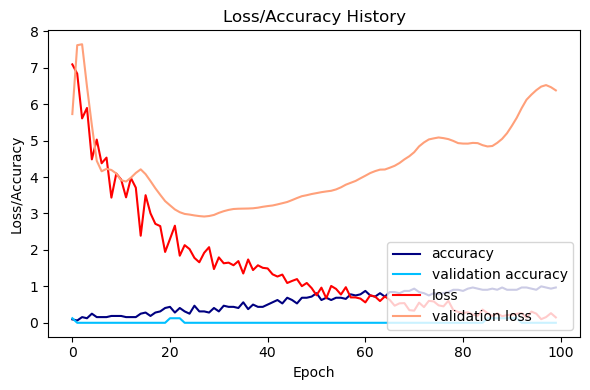

In [35]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.savefig("/Users/chloezhao/summer 2024 project/summer-project/figures/Loss-Accuracy-Notes")
plt.show()

In [36]:
test_predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


In [37]:
predicted_class_indices = np.argmax(test_predictions, axis=1)
predicted_classes = le.inverse_transform(predicted_class_indices)
print(predicted_classes)

[ 8  0  0  8 10 10  8  4]


In [38]:
y_true = np.argmax(y_test, axis=1)
true_classes = le.inverse_transform(y_true)
print(true_classes)

[ 3 11  5  7  6 11  0 11]


In [41]:
unique_labels = np.unique(np.concatenate([y_true, predicted_class_indices]))


# Calculate accuracy
accuracy = accuracy_score(y_true, predicted_class_indices)
print("Accuracy:", accuracy)


# Generate a classification report
#print(classification_report(y_true, predicted_class_indices, labels=unique_labels, target_names=le.inverse_transform(unique_labels)))


# Confusion matrix
cm = confusion_matrix(y_true, predicted_class_indices)
print("Confusion Matrix:\n", cm)

Accuracy: 0.0
Confusion Matrix:
 [[0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 1 0]]


In [40]:


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/Users/chloezhao/summer 2024 project/summer-project/figures/Confusion-Matrix-Notes")
plt.show()


NameError: name 'cm' is not defined

<Figure size 1000x800 with 0 Axes>